This notebook explore using Snorkel to weak supervised learning. We use labeling functions generated labels for unlabeled data. 

By Bharath Gunasekaran





## Installing Dependencies

In [ ]:
# To install only the requirements of this notebook, uncomment the lines below and run this cell

# ===========================

!pip install numpy==1.19.5
!pip install pandas==1.1.5
!pip install wget==3.2
!pip install matplotlib==3.2.2
!pip install utils==1.0.1
!pip install snorkel==0.9.6
!pip install scikit-learn==0.21.3
!pip install textblob==0.15.3
!pip install treedlib==0.1.3
!pip install numbskull==0.1.1
!pip install spacy==2.2.4

# ===========================

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=8d8237eb2adfc373e7d289b0eb2278cc8ddfe78069d49234264ca1777ad35cf8
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
     |████████████████████████████████| 144 kB 5.1 MB/s 
     |████████████████████████████████| 6.7 MB 30.9 MB/s 
     |████████████████████████████████| 3.8 MB 54.5 MB/s 
     |████████████████████████████████| 1.7 MB 71.2 MB/s 
  Created wheel for networkx: filename=networkx-2.3-py2.py3-none-any.whl size=1556009 sha256=6375daa0a9743f95a9a172072460d855e2a5ba2f326a60139b1950c993d928ce
  Stored in directory: /root/.cache/pip/wheels/44/e6/b8/4efaab31158e9e9ca9ed80b11f6b11130bac9a9672b3cbbeaf
Successfully built networkx
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.7.0
    Uninstalling tensorboard-2.7.0:
      Successfully uninstalled tensorboard-2.7.0
  Attempting uninstall: scikit

In [ ]:
# To install the requirements for the entire chapter, uncomment the lines below and run this cell

# ===========================

try :
    import google.colab
    !curl https://raw.githubusercontent.com/practical-nlp/practical-nlp/master/Ch2/ch2-requirements.txt | xargs -n 1 -L 1 pip install
except ModuleNotFoundError :
    !pip install -r "ch2-requirements.txt"

# ===========================

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   304  100   304    0     0   2140      0 --:--:-- --:--:-- --:--:--  2140
  Created wheel for pytesseract: filename=pytesseract-0.3.7-py2.py3-none-any.whl size=13954 sha256=5c91ef8550fa46180d9140c0f1f6c5dfc36939243cb17d85e78c07f68623a554
  Stored in directory: /root/.cache/pip/wheels/67/71/6c/7a8c5ca2e699752506999ae7baeb692e2b4fc6488c2cddcb22
Successfully built pytesseract
     |████████████████████████████████| 101 kB 2.5 MB/s 
     |████████████████████████████████| 412.3 MB 24 kB/s 
     |████████████████████████████████| 50 kB 8.8 MB/s 
     |████████████████████████████████| 503 kB 57.8 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=9ecf4cc76970d94e26199ef3e0675e545724d39c9817bf4a8279aa1fc3709f6b
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f55

In [ ]:
!pip install tensorflow==1.15
!pip install tensorboard==1.15
!python -m spacy download en_core_web_sm

     |████████████████████████████████| 12.0 MB 5.0 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [ ]:
import warnings
warnings.filterwarnings('ignore')

## Dataset
Let's get the Youtube spam classification dataset from the UCI ML Repository archive. The link for the dataset can be found [here](http://archive.ics.uci.edu/ml/machine-learning-databases/00380/YouTube-Spam-Collection-v1.zip).

In [ ]:
import os
import wget

import zipfile
import shutil

file_link = "http://archive.ics.uci.edu/ml/machine-learning-databases/00380/YouTube-Spam-Collection-v1.zip"

os.makedirs("content", exist_ok= True)
if not os.path.exists("content/YouTube-Spam-Collection-v1.zip"):
    wget.download(file_link, out="content/")
else:
    print("File already exists")

with zipfile.ZipFile("content/YouTube-Spam-Collection-v1.zip", 'r') as zip_ref:
    zip_ref.extractall("content/")

shutil.rmtree("content/__MACOSX")
os.remove("content/YouTube-Spam-Collection-v1.zip")
os.listdir("content")

['Youtube04-Eminem.csv',
 'Youtube02-KatyPerry.csv',
 'Youtube01-Psy.csv',
 'Youtube05-Shakira.csv',
 'Youtube03-LMFAO.csv']

Let's clone the necessary repos.

In [ ]:
!git clone https://github.com/snorkel-team/snorkel-tutorials.git

source = "content/"
destination = "snorkel-tutorials/spam/data/"

os.makedirs(destination, exist_ok= True)

files = os.listdir(source)

for file in files:
    new_path = shutil.move(f"{source}/{file}", destination)

os.chdir("snorkel-tutorials/spam")

Cloning into 'snorkel-tutorials'...
remote: Enumerating objects: 1104, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 1104 (delta 14), reused 18 (delta 8), pack-reused 1059
Receiving objects: 100% (1104/1104), 3.53 MiB | 18.92 MiB/s, done.
Resolving deltas: 100% (729/729), done.


## Making the necessary imports

In [ ]:
import re
import glob

import utils

from snorkel.analysis import get_label_buckets

from snorkel.labeling import labeling_function
from snorkel.labeling import LFAnalysis
from snorkel.labeling import PandasLFApplier
from snorkel.labeling import LabelingFunction
from snorkel.labeling.model import MajorityLabelVoter
from snorkel.labeling.model import LabelModel
from snorkel.labeling import filter_unlabeled_dataframe
from snorkel.labeling.lf.nlp import nlp_labeling_function

from snorkel.preprocess import preprocessor
from snorkel.preprocess.nlp import SpacyPreprocessor

from snorkel.utils import probs_to_preds

from textblob import TextBlob

import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def load_spam_dataset(load_train_labels: bool = False, split_dev_valid: bool = False):
    filenames = sorted(glob.glob("data/Youtube*.csv"))
    dfs = []
    for i, filename in enumerate(filenames, start=1):
        df = pd.read_csv(filename)
        # Lowercase column names
        df.columns = map(str.lower, df.columns)
        # Remove comment_id field
        df = df.drop("comment_id", axis=1)
        # Add field indicating source video
        df["video"] = [i] * len(df)
        # Rename fields
        df = df.rename(columns={"class": "label", "content": "text"})
        # Shuffle order
        df = df.sample(frac=1, random_state=123).reset_index(drop=True)
        dfs.append(df)

    df_train = pd.concat(dfs[:4])
    df_dev = df_train.sample(100, random_state=123)

    if not load_train_labels:
        df_train["label"] = np.ones(len(df_train["label"])) * -1
    df_valid_test = dfs[4]
    df_valid, df_test = train_test_split(
        df_valid_test, test_size=250, random_state=123, stratify=df_valid_test.label
    )

    if split_dev_valid:
        return df_train, df_dev, df_valid, df_test
    else:
        return df_train, df_test

In [ ]:
df_train, df_test = load_spam_dataset()
print("Train")
display(df_train.head())
print('Test')
df_test.head()

Train


,author,date,text,label,video
0,Alessandro leite,2014-11-05T22:21:36,pls http://www10.vakinha.com.br/VaquinhaE.aspx...,-1.0,1
1,Salim Tayara,2014-11-02T14:33:30,"if your like drones, plz subscribe to Kamal Ta...",-1.0,1
2,Phuc Ly,2014-01-20T15:27:47,go here to check the views :3﻿,-1.0,1
3,DropShotSk8r,2014-01-19T04:27:18,"Came here to check the views, goodbye.﻿",-1.0,1
4,css403,2014-11-07T14:25:48,"i am 2,126,492,636 viewer :D﻿",-1.0,1


Test


,author,date,text,label,video
27,‫حلم الشباب‬‎,2015-05-25T23:42:49.533000,Check out this video on YouTube:﻿,1,5
194,MOHAMED THASLEEM,2015-05-24T07:03:59.488000,super music﻿,0,5
277,AlabaGames,2015-05-22T00:31:43.922000,Subscribe my channel I RECORDING FIFA 15 GOAL...,1,5
132,Manish Ray,2015-05-23T08:55:07.512000,This song is so beauty,0,5
163,Sudheer Yadav,2015-05-28T10:28:25.133000,SEE SOME MORE SONG OPEN GOOGLE AND TYPE Shakir...,1,5


In [ ]:
Y_test = df_test.label.values
Y_test[:5]

array([1, 0, 1, 0, 1])

There are a few things to keep in mind with respect to the dataset:
1. HAM represents a NON-SPAM comment.
2. SPAM is a SPAM comment
3. ABSTAIN is for neither of the above

We initialise their respective values below


In [ ]:
ABSTAIN = -1
HAM = 0
SPAM = 1

We need to find some pattern in the data, so as to create rules for labeling the data.<br>
Hence, we randomly display some rows of the dataset so that we can try to find some pattern in the text. 

In [ ]:
df_train[["author", "text", "video"]].sample(20, random_state=2020)

,author,text,video
240,Lucas Trigo,WHATS UP EVERYONE!? :-) I Trying To Showcase M...,1
211,Blaze Rod,when i see this back in 2015 i ask myself how ...,3
228,MasterRobotTV,http://www.twitch.tv/zxlightsoutxz﻿,1
207,Franklin Music,Very Nice !﻿,3
153,lebanonwarior1,Song name??﻿,1
8,yenis maría Rodríguez,2015 LIKEEE﻿,3
62,RapStarz Coleman,Subscribe To Mê Please Guys,4
54,Jd Hurst,Check out this video on YouTube:﻿,3
353,jefflynnejp,Check out this video on YouTube: ﻿,3
406,eliška žáková,CUTE :)﻿,3


In [ ]:
#using regular expressions
@labeling_function()
def regex_check_out(x):
    return SPAM if re.search(r"check.*out", x.text, flags=re.I) else ABSTAIN

In [ ]:
@preprocessor(memoize=True)
def textblob_sentiment(x):
    scores = TextBlob(x.text)
    x.polarity = scores.sentiment.polarity
    x.subjectivity = scores.sentiment.subjectivity
    return x

In [ ]:
@labeling_function(pre=[textblob_sentiment])
def textblob_polarity(x):
    return HAM if x.polarity > 0.9 else ABSTAIN

@labeling_function(pre=[textblob_sentiment])
def textblob_subjectivity(x):
    return HAM if x.subjectivity >= 0.5 else ABSTAIN


In [ ]:
lfs = [textblob_polarity, textblob_subjectivity]

applier = PandasLFApplier(lfs)
L_train = applier.apply(df_train)


100%|██████████| 1586/1586 [00:01<00:00, 1356.14it/s]


In [ ]:
LFAnalysis(L_train, lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
textblob_polarity,0,[0],0.035309,0.013871,0.0
textblob_subjectivity,1,[0],0.357503,0.013871,0.0


## Writing more labeling functions

Single labeling functions arent enough to test the entire databsase with accuracy as they do not have enough coverage, we usually need to combine differnt labeling functions(more rubost and accurate ones) to get this done.

**Keyword based labeling fucntions**: These are similar to the ones used befeore with the labeling_fucntion decorator. here we just make a few changes

In [ ]:
def keyword_lookup(x, keywords, label):
    if any(word in x.text.lower() for word in keywords):
        return label
    return ABSTAIN


def make_keyword_lf(keywords, label=SPAM):
    return LabelingFunction(
        name=f"keyword_{keywords[0]}",
        f=keyword_lookup,
        resources=dict(keywords=keywords, label=label),
    )


"""Spam comments talk about 'my channel', 'my video', etc."""
keyword_my = make_keyword_lf(keywords=["my"])

"""Spam comments ask users to subscribe to their channels."""
keyword_subscribe = make_keyword_lf(keywords=["subscribe"])

"""Spam comments post links to other channels."""
keyword_link = make_keyword_lf(keywords=["http"])

"""Spam comments make requests rather than commenting."""
keyword_please = make_keyword_lf(keywords=["please", "plz","pls"])

"""Spam comments asking for views"""
keyword_view = make_keyword_lf(keywords=['view','look at'])

"""Ham comments actually talk about the video's content."""
keyword_song = make_keyword_lf(keywords=["song"], label=HAM)



Modifying the above functions to use regualr expressions too would be an interesting exercise which we will leave to the reader.

Having other methods such as a Rule of Thumb or Heuristics(length of text) could help too. These are not extremely accurate but will get the job done to a certain extent.

An example is given below

In [ ]:
@labeling_function()
def short_comment(x):
    """Ham comments are often short, such as 'cool video!'"""
    return HAM if len(x.text.split()) < 5 else ABSTAIN

We can also use NLP preprocessors such as spaCy to enrich our data and provide us with more fields to work on which will make the labeling a bit easier . 

In [ ]:
# The SpacyPreprocessor parses the text in text_field and
# stores the new enriched representation in doc_field
spacy = SpacyPreprocessor(text_field="text", doc_field="doc", memoize=True)

@labeling_function(pre=[spacy])
def has_person(x):
    """Ham comments mention specific people and are short."""
    if len(x.doc) < 20 and any([ent.label_ == "PERSON" for ent in x.doc.ents]):
        return HAM
    else:
        return ABSTAIN

In [ ]:
#snorkel has a pre built labeling function like decorator that uses spaCy as it is a very common nlp preprocessor

@nlp_labeling_function()
def has_person_nlp(x):
    """Ham comments mention specific people and are short."""
    if len(x.doc) < 20 and any([ent.label_ == "PERSON" for ent in x.doc.ents]):
        return HAM
    else:
        return ABSTAIN


## Outputs
Let's move onto learning how we can go about combining labeling function outputs with labeling models.



In [ ]:
lfs = [
    keyword_my,
    keyword_subscribe,
    keyword_link,
    keyword_please,
    keyword_song,
    keyword_view,
    regex_check_out,
    short_comment,
    has_person_nlp,
    textblob_polarity,
    textblob_subjectivity,
]


In [ ]:
applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=df_train)
L_test = applier.apply(df=df_test)

100%|██████████| 250/250 [00:00<00:00, 6227.73it/s]


In [ ]:
LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
keyword_my,0,[1],0.198613,0.187264,0.110340
keyword_subscribe,1,[1],0.127364,0.110340,0.068096
keyword_http,2,[1],0.119168,0.104035,0.083228
keyword_please,3,[1],0.114754,0.112232,0.057377
keyword_song,4,[0],0.141866,0.112863,0.049811
keyword_view,5,[1],0.083228,0.058638,0.044767
regex_check_out,6,[1],0.233922,0.133039,0.086381
short_comment,7,[0],0.225725,0.147541,0.078815
has_person_nlp,8,[0],0.082598,0.062421,0.029634
textblob_polarity,9,[0],0.035309,0.032156,0.006936


We plot a histogram to get an idea about the coverages of the labeling functions

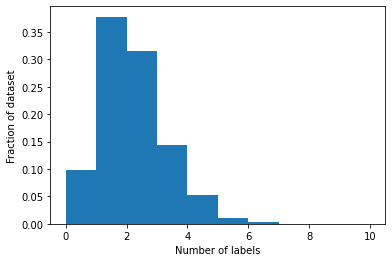

In [ ]:
def plot_label_frequency(L):
    plt.hist((L != ABSTAIN).sum(axis=1), density=True, bins=range(L.shape[1]))
    plt.xlabel("Number of labels")
    plt.ylabel("Fraction of dataset")
    plt.show()


plot_label_frequency(L_train)

We now convert the labels from our labeling functions to a single noise-aware probabilistic label per data. we do so by taking a majority vote on what the data should be labeled as .i.e if more labeling functions agree that the text/data is spam , then we label it as spam

In [ ]:
majority_model = MajorityLabelVoter()
preds_train = majority_model.predict(L=L_train)

In [ ]:
preds_train

array([1, 1, 1, ..., 1, 1, 1])

However there may be functions that are correlated and might give a false sense of majority , to handle this we use a differernt snorkel label model to comine inputs of the labeling functions.

In [ ]:
label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train=L_train, n_epochs=500, log_freq=100, seed=123)

In [ ]:
majority_acc = majority_model.score(L=L_test, Y=Y_test, tie_break_policy="random")["accuracy"]
print(f"{'Majority Vote Accuracy:':<25} {majority_acc * 100:.1f}%")

label_model_acc = label_model.score(L=L_test, Y=Y_test, tie_break_policy="random")["accuracy"]
print(f"{'Label Model Accuracy:':<25} {label_model_acc * 100:.1f}%")

Majority Vote Accuracy:   84.0%
Label Model Accuracy:     86.4%


We plot another graph to see the confidences that each data point is a spam

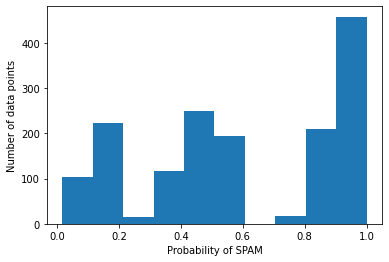

In [ ]:
def plot_probabilities_histogram(Y):
    plt.hist(Y, bins=10)
    plt.xlabel("Probability of SPAM")
    plt.ylabel("Number of data points")
    plt.show()

probs_train = label_model.predict_proba(L=L_train)
plot_probabilities_histogram(probs_train[:, SPAM])


There might be some data which do not get any label from the functions , we filter them out as follows

In [ ]:
df_train_filtered, probs_train_filtered = filter_unlabeled_dataframe(
    X=df_train, y=probs_train, L=L_train
)

## Training a classifier
In this section we use the probabilistic training labels we generated to train a classifier. for demonstration we use Scikit-Learn.<br>
_Note:Do not worry if you do not understand what a classifier is. We cover all of this in Chapter 4. Please read Ch4 and look at the jupyter notebooks in Ch4._

In [ ]:
vectorizer = CountVectorizer(ngram_range=(1, 5))
X_train = vectorizer.fit_transform(df_train_filtered.text.tolist())
X_test = vectorizer.transform(df_test.text.tolist())


In [ ]:
preds_train_filtered = probs_to_preds(probs=probs_train_filtered)

In [ ]:
sklearn_model = LogisticRegression(C=1e3, solver="liblinear")
sklearn_model.fit(X=X_train, y=preds_train_filtered)

LogisticRegression(C=1000.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
print(f"Test Accuracy: {sklearn_model.score(X=X_test, y=Y_test) * 100:.1f}%")


Test Accuracy: 93.6%


We have just scratched the surface on what snorkel can do. We highly recommend going through their [github](https://github.com/snorkel-team/snorkel) and [tutorials](https://github.com/snorkel-team/snorkel-tutorials).